# Librairies

In [1]:
import glob
from pathlib import Path
import os
import sys
from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import geopandas as gpd

from PIL import Image, ImageMath

import math

import warnings
import logging

from keras.layers import Input, Dense, Conv1D, Conv2D, concatenate, Flatten, MaxPooling2D, Dropout
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam, RMSprop, SGD
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.regularizers import l1 
    
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

from pytictoc import TicToc

from numpy.random import seed
seed(1)



/home/charles/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
rootDir = '/home/charles/Projects/NeuralNetPopulation'
provider = 'Mapbox'
gridSize = 100
resp="v_CA16_406"
finalNonLin = 'linear'
optimizerClass = Adam
lrInit=10**-2

In [3]:
sys.path.append("/home/charles/Projects/NeuralNetPopulation/Python") #watch out, PosixPath do not work

from dataGeneration.dataGeneratorFactory import DataGeneratorFactory
from dataGeneration.rawDataInput import RawDataInput

from models.convNetParams import ConvNetParams
from models.mdlFit import MdlFit
from utils.pathBuilder import PathBuilder

In [4]:
#Limit the number of images read in memory
ubNumTotal = 50

# Load the model, and dataloader objects

In [5]:
myPathBuilder = PathBuilder(rootDir,
                                provider,
                                gridSize)

myRawDataInput = RawDataInput(myPathBuilder,
                                  idGrid='gridId',
                                  provider=provider,
                                  gridSize=gridSize,
                                  resp=resp,
                                  ubNumTotal=ubNumTotal)  # consider a small subset


Directory /home/charles/Projects/NeuralNetPopulation/Data/Models/PredictionError/Mapbox/100 already exists
Directory /home/charles/Projects/NeuralNetPopulation/Data/Models/Partition/Mapbox/100 already exists
Directory /home/charles/Projects/NeuralNetPopulation/Figures/Mapbox/100 already exists
Directory /home/charles/Projects/NeuralNetPopulation/Data/Models/FinalModel/Mapbox/100 already exists
Directory /home/charles/Projects/NeuralNetPopulation/Data/Models/ModelHistory/Mapbox/100 already exists
Directory /home/charles/Projects/NeuralNetPopulation/Log/mdlFittingLogs/Mapbox/100 already exists
Directory /home/charles/Projects/NeuralNetPopulation/Data/Models/Checkpoint/Mapbox/100 already exists
Directory /home/charles/Projects/NeuralNetPopulation/Data/Models/FeatureMaps/Mapbox/100 already exists


## tanh + relu

In [6]:
myConvNetParams = ConvNetParams(provider=provider,
                                    gridSize=gridSize,
                                    resp=myRawDataInput.resp,
                                    dim=myRawDataInput.dim,
                                    numImgs=myRawDataInput.numImgs,
                                    penultimateNonLin ='tanh',
                                    finalNonLin='relu',
                                    lr=lrInit,
                                    numEpochs=20,
                                    batchSize=2 ** 5,
                                    l1Coeff=0,
                                    dropoutRate=0.1,
                                    convNetClass=VGG19,
                                    scalerClass=MinMaxScaler,
                                    shuffle=False,
                                    verbose=True)

myDatageneratorFactory = DataGeneratorFactory(myRawDataInput,
                                                  myConvNetParams,
                                                  myPathBuilder)

dictTrainTestValid=myDatageneratorFactory.getTrainTestValidDataGenerators()
 

mdl_TanhRelu = load_model( myPathBuilder.modelsOutputPath / 'model_Mapbox_v_CA16_406_VGG19_gridSize_100_lr_0.01_batchSize_32_numEpochs_30_l1Coeff_0_dropoutRate_0_numImgs_4104_scalerMinMaxScaler_optimizerName_SGDfinalNonLinearity_linear_penultimateNonLin_tanh.h5')

All train, test, valid indices already exist for Mapbox_v_CA16_406_VGG19_gridSize_100_lr_0.01_batchSize_32_numEpochs_20_l1Coeff_0_dropoutRate_0.1_numImgs_50_scalerMinMaxScaler_optimizerName_SGDfinalNonLinearity_relu_penultimateNonLin_tanh
The number of indices must be at least as large as the batch size! Cannot consider a batch of size 28 with only 28 items
Using a scale factor of 255.0 in DataGenerator
The number of indices must be at least as large as the batch size! Cannot consider a batch of size 8 with only 8 items
Using a scale factor of 255.0 in DataGenerator
The number of indices must be at least as large as the batch size! Cannot consider a batch of size 6 with only 6 items
Using a scale factor of 255.0 in DataGenerator


In [90]:
[l.name for l in mdl_TanhRelu.layers]

['input_2', 'model_2', 'flatten', 'fc2', 'dropout_1', 'predictions']

# Evaluate predictions and errors

## Parameters for number of obs for test

In [7]:
numImgBatches=1 #batches of 32
maxNumImgs=50

if numImgBatches > 10**3/32 or maxNumImgs > 10**3:
    raise Exception("You will run out of RAM! Use generators, don't try to load the entire set of images into memory at once")

## Get the train and test sets

In [8]:
def getTrainTestRAM(dictTrainTestValid):
 
    dictX={}
    dictY={}
    for k in dictTrainTestValid.keys():
        
        #Iterator over the image enerator and load into memory
        listTupleXy = [ (X,y) for k,(X,y) in enumerate(dictTrainTestValid[k]) if k <= numImgBatches ]

        #Get the response
        y = np.concatenate( [tup[1] for tup in listTupleXy ])
        numImgs =min(maxNumImgs, y.shape[0])
        y=y[:numImgs]

        #Get the images/covariates
        X = np.concatenate( [tup[0]  for tup in listTupleXy ] )
        X =X [:numImgs,:,:,:]
        
        dictX[k] = X
        dictY[k] = y

    return dictX, dictY

In [9]:
dictX, dictY=getTrainTestRAM(dictTrainTestValid)
 

# Get the feature map before the (affine + possible nonlinear) prediction

In [104]:
def getDfFeatureMap(mdl,X,useFlat=False):
    
    #Build the submodel
    inputLyr=mdl.layers[0]
    if useFlat:
        fcLyr =mdl.get_layer('flatten') #Consider the overall model, not the vgg feature extraction
    else:
        fcLyr =mdl.get_layer('fc2') #Consider the overall model, not the vgg feature extraction
    
    subMdl=Model(inputLyr.input, fcLyr.output )
    
    #Get the last feature maps
    listPred=subMdl.predict(X)  
    
    #Cram into a df where each column corresponds to an observation/imae
    dfFeatMap = pd.DataFrame( listPred.T )
    
    return dfFeatMap

# Inspect distribution of feature map

In [115]:
dictFeatMap={}
listDf=[]
useFlat=False
for k,val in dictX.items():
        dictFeatMap[k] = getDfFeatureMap(mdl_TanhRelu, dictX[k], useFlat=useFlat)
        dfMelt=pd.melt(dictFeatMap[k])
        dfMelt['id'] =k
        listDf.append(dfMelt)

In [116]:
listT=[]
for i in dictFeatMap.keys():
    
    dfT=dictFeatMap[i].T
    newColNames={i: f'dim{i}' for i in range(dfT.shape[1])}
    dfT.rename(columns=newColNames,inplace=True)
    dfT['id'] = i
    listT.append(dfT)
    
dfFeatMapAll= pd.concat(listT)
dfFeatMapAll.reset_index(inplace=True)
dfFeatMapAll['obs'] = range(dfFeatMapAll.shape[0])
print(dfFeatMapAll.shape)
dfFeatMapAll.head()

(42, 19)


index  dim0  dim1  dim2  dim3  dim4  dim5  dim6  dim7  dim8  dim9  dim10  \
0      0  -1.0   1.0   1.0  -1.0  -1.0  -1.0   1.0   1.0  -1.0   1.0    1.0   
1      1  -1.0   1.0   1.0  -1.0  -1.0  -1.0   1.0   1.0  -1.0   1.0    1.0   
2      2  -1.0   1.0   1.0  -1.0  -1.0  -1.0   1.0   1.0  -1.0   1.0    1.0   
3      3  -1.0   1.0   1.0  -1.0  -1.0  -1.0   1.0   1.0  -1.0   1.0    1.0   
4      4  -1.0   1.0   1.0  -1.0  -1.0  -1.0   1.0   1.0  -1.0   1.0    1.0   

   dim11  dim12  dim13  dim14  dim15     id  obs  
0    1.0   -1.0   -1.0    1.0   -1.0  train    0  
1    1.0   -1.0   -1.0    1.0   -1.0  train    1  
2    1.0   -1.0   -1.0    1.0   -1.0  train    2  
3    1.0   -1.0   -1.0    1.0   -1.0  train    3  
4    1.0   -1.0   -1.0    1.0   -1.0  train    4

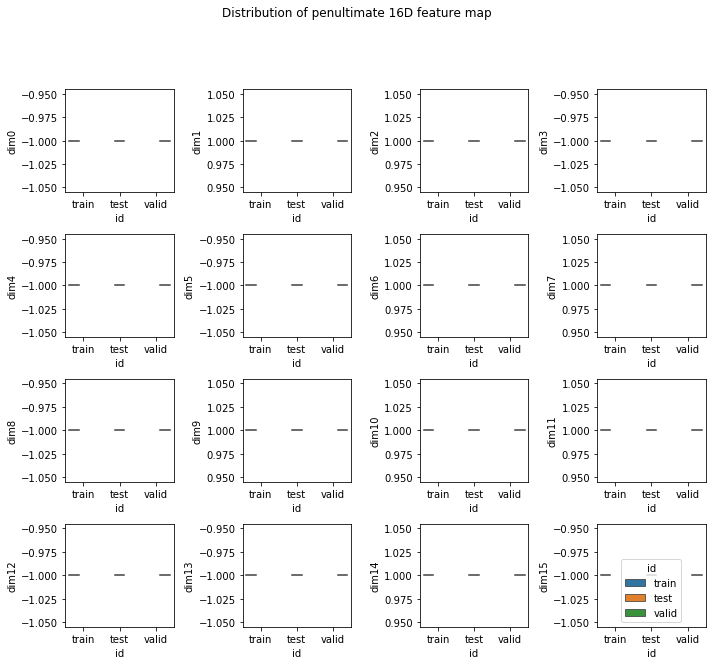

In [120]:
plt.figure(figsize=(10,10))
strName = 'Distribution of flatten layer after feature extractor' if useFlat else 'Distribution of penultimate 16D feature map'
for r in range(4):
    for c in range(4):
        k=r+c*4+1
        plt.subplot(4,4,k)
        ax=sns.violinplot(x='id', y=f'dim{k-1}', hue='id',data=dfFeatMapAll.loc[:,[f'dim{k-1}','id']],label='id')
        if k < 16:
            ax.get_legend().set_visible(False)
plt.suptitle(strName,y=0.95)
plt.tight_layout(rect=[0, 0.03, 1, 0.85])

plt.savefig( myPathBuilder.figuresOutputPath / "FeatureMaps" / f"featMapDistri_useFlat_{useFlat}_{myConvNetParams.mdlId}.png")